In [858]:
"""
This script downloads census data exports county level data to an excel file and tract level data to shapefiles.
Other notes: 
This script will be built out to include all relevant census variables. 
Environment is based off of Pin-Up environment. Jupytext and o
"""

"""
TO DO 
-Clean up Script
-Turn Script into function
-Further simplify/aggregate countywide stat excel outputs. 


"""

'\nTO DO \n-Clean up Script\n-Turn Script into function\n-Further simplify/aggregate countywide stat excel outputs. \n\n\n'

In [859]:
#import necessary libraries

import requests
import pandas as pd
import geopandas as gpd
import numpy as np
# import geojson
import folium
import os


In [1091]:
# FIPS CODES
Alameda = "001"
Contra_Costa = "013"
Solano = "095"
San_Francisco = "075"



In [1092]:
#For each iteration change the county
county = Alameda

In [1093]:
#Set output filepaths
Equity_Tracts = f'/Users/calvindechicago/PycharmProjects/AltaWork/AltaProjects/EBRPD/Equity_Data/equity_tracts_{county}.shp'

Transportation_Tracts = '/Users/calvindechicago/PycharmProjects/AltaWork/AltaProjects/EBRPD/Equity_Data/transportation_tracts.shp'

Age_Tracts = '/Users/calvindechicago/PycharmProjects/AltaWork/AltaProjects/EBRPD/Equity_Data/tract_age.shp'

EXCEL_FP = f'/Users/calvindechicago/PycharmProjects/AltaWork/AltaProjects/EBRPD/Equity_Data/countylevel_demographics_{county}.xlsx'

In [1094]:
#These are all of the main variables used to build a call url to the the census api website
#Available APIs (--> 2018 ACS Detailed Tables Variables [ html | xml | json ])
#https://www.census.gov/data/developers/data-sets.html

HOST = "https://api.census.gov/data"
year = "2018"
#dataset = "acs/acs5/subject"
dataset = "acs/acs5"
api_key = "f9e79198302081250c07d556f35d8a81cdae528a"
base_url = "/".join([HOST, year, dataset,])

In [1095]:
# Setup request for Table B08006: Sex of Workers by Means of Transportation to Work
# Setup request for Table B08014: SEX OF WORKERS BY VEHICLES AVAILABLE (Total and No vehicle columns only)
# (COUNTY LEVEL)
request_predicates = {}
get_vars_transpo_mode = ["NAME","B08006_001E","B08006_002E","B08006_003E", "B08006_004E",
                         "B08006_008E","B08006_014E","B08006_015E","B08006_016E", 
                         "B08006_017E", "GEO_ID", "B08014_001E", "B08014_002E" 
                        ]
col_names_transpo_mode = ["place_name", "total","total_car_truck_van",
                          "car_truck_van_drove_alone","car_truck_van_carpooled",
                          "public_transportation", "bike", "walk", "taxi_moto_other",
                          "work_from_home","geoid", "total_workers", "no_vehicle",
                          "state_code", "county"
                         ]

request_predicates["key"] = api_key
request_predicates["get"] = ",".join(get_vars_transpo_mode)


#THESE PREDICATES GET AGGREGATE TOTALS FOR ENTIRE COUNTY (SACRAMENTO)
#request_predicates["for"] = "county:067" #Sacramento
request_predicates["for"] = f"county:{county}"  
request_predicates["in"] = "state:06"

transpo_mode_county = requests.get(base_url, params=request_predicates)
num_columns = 15

In [1096]:
#Setting up Means of Transportation to Workdata frame, getting rid of first header row
df_transpo_mode_county = pd.DataFrame(columns=col_names_transpo_mode, data=transpo_mode_county.json()[1:])

In [1097]:
# THESE PREDICATES GET DATA FOR EVERY TRACT in County
# These revised predicates replace the 'for' and 'in' predicates above.
#(TRACT LEVEL)

request_predicates["for"] = "tract:*"
#request_predicates["in"] = "state:06+county:067"
request_predicates["in"] = f"state:06+county:{county}"

transpo_mode_tracts = requests.get(base_url, params=request_predicates)



In [1098]:
#Setting up Means of Transportation to Work at Tract Level data frame, getting rid of first header row
#This includes appending 'tract' to columns list
col_names_transpo_mode = ["place_name", "total","total_car_truck_van",
                          "car_truck_van_drove_alone","car_truck_van_carpooled",
                          "public_transportation", "bike", "walk", "taxi_moto_other",
                          "work_from_home","geoid", "total_workers", "no_vehicle","state_code",
                          "county", "tract" 
                         ]
df_transpo_mode_tracts = pd.DataFrame(columns=col_names_transpo_mode, data=transpo_mode_tracts.json()[1:])
num_columns = 16

In [1099]:
dtype_conversion = { "total": int,
                    "total_car_truck_van": int,
                    "car_truck_van_drove_alone": int,
                    "car_truck_van_carpooled": int,
                    "public_transportation": int,
                    "bike": int,
                    "walk": int, 
                    "taxi_moto_other": int, 
                    "work_from_home": int, 
                    "total_workers": int, 
                    "no_vehicle": int
                }

df_transpo_mode_tracts = df_transpo_mode_tracts.astype(dtype_conversion) 

In [1100]:
df_transpo_mode_tracts["pct_no_veh"] = (df_transpo_mode_tracts["no_vehicle"]/df_transpo_mode_tracts["total_workers"]*100)

In [1101]:
#The geoid field in the df_transpo_mode table does not match the Tigerlines geoid field. 
#This slices the the right 11 most digits, which match the geoid codes in the TigerLine file. 
#(... these are state ('06') for California, followed by county, followed by census tract)

df_transpo_mode_tracts.insert(num_columns, "geoid_join",df_transpo_mode_tracts['geoid'].str.slice(-11), True) 



In [1102]:
## SETUP FOR TABLE B08001: SEX BY AGE
#NAME dropped from request because only 50 variables per request are permitted.
request_predicates = {}
get_vars_age = ["B01001_001E", "B01001_002E","B01001_003E", "B01001_004E","B01001_005E", 
                "B01001_006E", "B01001_007E","B01001_008E", "B01001_009E","B01001_010E", 
                "B01001_011E", "B01001_012E","B01001_013E", "B01001_014E","B01001_015E", 
                "B01001_016E", "B01001_017E","B01001_018E", "B01001_019E","B01001_020E", 
                "B01001_021E", "B01001_022E","B01001_023E", "B01001_024E","B01001_025E", 
                "B01001_026E", "B01001_027E","B01001_028E", "B01001_029E","B01001_030E", 
                "B01001_031E", "B01001_032E","B01001_033E", "B01001_034E","B01001_035E", 
                "B01001_036E", "B01001_037E","B01001_038E", "B01001_039E","B01001_040E", 
                "B01001_041E", "B01001_042E","B01001_043E", "B01001_044E","B01001_045E", 
                "B01001_046E", "B01001_047E","B01001_048E", "B01001_049E","GEO_ID"
                ]

col_names_age = ["total_pop","total_male","tl_m0_5","tl_m5_9", "tl_m10_14", "tl_m15_17", 
                 "tl_m18_19", "tl_m20", "tl_m21", "tl_m22_24", "tl_m25_29", "tl_m30_34",
                 "tl_m35_39", "tl_m40_44", "tl_m45_49", "tl_m50_54", "tl_m55_59", "tl_m60_61",
                 "tl_m62_64", "tl_m65_66", "tl_m67_69", "tl_m70_74", "tl_m75_79", "tl_m80_84",
                 "tl_m85_pl","total_female", "tl_f0_5","tl_f5_9", "tl_f10_14", "tl_f15_17", 
                 "tl_f18_19", "tl_f20", "tl_f21", "tl_f22_24", "tl_f25_29", "tl_f30_34",
                 "tl_f35_39", "tl_f40_44", "tl_f45_49", "tl_f50_54", "tl_f55_59", "tl_f60_61",
                 "tl_f62_64", "tl_f65_66", "tl_f67_69", "tl_f70_74", "tl_f75_79", "tl_f80_84",
                 "tl_f85_pl","geoid","state","county"
                ]

request_predicates["key"] = api_key
request_predicates["get"] = ",".join(get_vars_age)

#THESE PREDICATES GET AGGREGATE TOTALS FOR ENTIRE COUNTY (SACRAMENTO)
request_predicates["for"] = f"county:{county}"
request_predicates["in"] = "state:06"


age_county = requests.get(base_url, params=request_predicates)
num_columns = 49

In [1103]:
#Setting up AGE data frame, getting rid of first header row
df_age_county = pd.DataFrame(columns=col_names_age, data=age_county.json()[1:])

In [1104]:
# THESE PREDICATES GET DATA FOR EVERY TRACT

request_predicates["for"] = "tract:*"
request_predicates["in"] = f"state:06+county:{county}"
# request_predicates["in"] = "state:06+county:067"

age_tracts = requests.get(base_url, params=request_predicates)
num_columns = 50

In [1105]:
#Setting up AGE TRACTS data frame, getting rid of first header row
col_names_age = ["total_pop","total_male","tl_m0_5","tl_m5_9", "tl_m10_14", "tl_m15_17", 
                 "tl_m18_19", "tl_m20", "tl_m21", "tl_m22_24", "tl_m25_29", "tl_m30_34",
                 "tl_m35_39", "tl_m40_44", "tl_m45_49", "tl_m50_54", "tl_m55_59", "tl_m60_61",
                 "tl_m62_64", "tl_m65_66", "tl_m67_69", "tl_m70_74", "tl_m75_79", "tl_m80_84",
                 "tl_m85_pl","total_female", "tl_f0_5","tl_f5_9", "tl_f10_14", "tl_f15_17", 
                 "tl_f18_19", "tl_f20", "tl_f21", "tl_f22_24", "tl_f25_29", "tl_f30_34",
                 "tl_f35_39", "tl_f40_44", "tl_f45_49", "tl_f50_54", "tl_f55_59", "tl_f60_61",
                 "tl_f62_64", "tl_f65_66", "tl_f67_69", "tl_f70_74", "tl_f75_79", "tl_f80_84",
                 "tl_f85_pl","geoid","state","county", 'tract'
                ]
df_age_tracts = pd.DataFrame(columns=col_names_age, data=age_tracts.json()[1:])

In [1106]:
# using dictionary to convert specific columns 
# convert_dict = {'A': int, 
#                 'C': float
#                } 
  
# df = df.astype(convert_dict) 
# print(df.dtypes) 
dtype_conversion = { "total_pop": int,
                    "total_male": int,
                    "tl_m0_5": int,
                    "tl_m5_9": int,
                    "tl_m10_14": int,
                    "tl_m15_17": int,
                    "tl_m18_19": int, 
                    "tl_m20": int, 
                    "tl_m21": int, 
                    "tl_m22_24": int, 
                    "tl_m25_29": int, 
                    "tl_m30_34": int,
                    "tl_m35_39": int, 
                    "tl_m40_44": int, 
                    "tl_m45_49": int, 
                    "tl_m50_54": int, 
                    "tl_m55_59": int, 
                    "tl_m60_61": int,
                    "tl_m62_64": int, 
                    "tl_m65_66": int, 
                    "tl_m67_69": int, 
                    "tl_m70_74": int, 
                    "tl_m75_79": int, 
                    "tl_m80_84": int,
                    "tl_m85_pl": int,
                    "total_female": int, 
                    "tl_f0_5": int,
                    "tl_f5_9": int,
                    "tl_f10_14": int,
                    "tl_f15_17": int,
                    "tl_f18_19": int,
                    "tl_f20": int,
                    "tl_f21": int,
                    "tl_f22_24": int,
                    "tl_f25_29": int,
                    "tl_f30_34": int,
                    "tl_f35_39": int,
                    "tl_f40_44": int,
                    "tl_f45_49": int,
                    "tl_f50_54": int,
                    "tl_f55_59": int,
                    "tl_f60_61": int,
                    "tl_f62_64": int,
                    "tl_f65_66": int,
                    "tl_f67_69": int,
                    "tl_f70_74": int,
                    "tl_f75_79": int,
                    "tl_f80_84": int,
                    "tl_f85_pl": int,
                    "county": int,
                    'tract': int
                }
df_age_tracts = df_age_tracts.astype(dtype_conversion) 

In [1107]:
age_18_under = df_age_tracts["tl_m0_5"] + df_age_tracts["tl_f0_5"] + df_age_tracts["tl_m5_9"] + df_age_tracts["tl_m10_14"] + df_age_tracts["tl_m15_17"] + df_age_tracts["tl_f5_9"] + df_age_tracts["tl_f10_14"] + df_age_tracts["tl_f15_17"]

age_65_over = df_age_tracts["tl_f65_66"] + df_age_tracts["tl_f67_69"] + df_age_tracts["tl_f70_74"] + df_age_tracts["tl_f75_79"] + df_age_tracts["tl_f80_84"] + df_age_tracts["tl_f85_pl"] + df_age_tracts["tl_m65_66"] + df_age_tracts["tl_m67_69"] + df_age_tracts["tl_m70_74"] + df_age_tracts["tl_m75_79"] + df_age_tracts["tl_m80_84"] + df_age_tracts["tl_m85_pl"]

age_vulnerable = age_18_under + age_65_over



In [1108]:
df_age_tracts["age_18_under"] = age_18_under 
df_age_tracts["age_65_over"] = age_65_over
df_age_tracts["age_vulnerable"] = age_vulnerable

df_age_tracts["pct_age_18_under"] = df_age_tracts["age_18_under"]/df_age_tracts["total_pop"]*100
df_age_tracts["pct_age_65_over"] = df_age_tracts["age_65_over"]/df_age_tracts["total_pop"]*100
df_age_tracts["pct_age_vulnerable"] = df_age_tracts["age_vulnerable"]/df_age_tracts["total_pop"]*100




In [1109]:
df_age_tracts_simple = df_age_tracts[["total_pop","age_18_under","age_65_over","age_vulnerable", "pct_age_18_under","pct_age_65_over","pct_age_vulnerable","geoid","state","county","tract"]]

In [1110]:
df_age_tracts_simple.head(5)

,total_pop,age_18_under,age_65_over,age_vulnerable,pct_age_18_under,pct_age_65_over,pct_age_vulnerable,geoid,state,county,tract
0,6570,1265,1052,2317,19.254186,16.012177,35.266362,1400000US06001441501,06,1,441501
1,2079,453,391,844,21.789322,18.807119,40.596441,1400000US06001404700,06,1,404700
2,7748,1484,795,2279,19.153330,10.260712,29.414042,1400000US06001442500,06,1,442500
3,5301,1347,472,1819,25.410300,8.903980,34.314280,1400000US06001450300,06,1,450300
4,5971,1393,795,2188,23.329426,13.314353,36.643778,1400000US06001450607,06,1,450607


In [1111]:
#Add geoid_join column 
df_age_tracts_simple.insert(8, "geoid_join",df_transpo_mode_tracts['geoid'].str.slice(-11), True) 


In [1112]:
#B19013 Median Household Income - TRACT

# THESE PREDICATES GET DATA FOR EVERY TRACT
#NAME dropped from request because only 50 variables per request are permitted.
request_predicates = {}
get_vars_mhi = ["NAME","B19013_001E", "GEO_ID"
                ]

col_names_mhi = ["place_name", "mhi",
                 "geoid","state","county", "tract"
                ]

request_predicates["key"] = api_key
request_predicates["get"] = ",".join(get_vars_mhi)



request_predicates["for"] = "tract:*"
request_predicates["in"] = f"state:06+county:{county}"
# request_predicates["in"] = "state:06+county:067"

mhi_tracts = requests.get(base_url, params=request_predicates)
num_columns = 50



In [1113]:
#B19013 Median Household Income - COUNTY

request_predicates = {}
get_vars_mhi_county = ["NAME","B19013_001E", "GEO_ID"
                ]

col_names_mhi_county = ["place_name", "mhi",
                 "geoid","state","county"
                ]

request_predicates["key"] = api_key
request_predicates["get"] = ",".join(get_vars_mhi_county)


#THESE PREDICATES GET AGGREGATE TOTALS FOR ENTIRE COUNTY (SACRAMENTO)
#request_predicates["for"] = "county:067" #Sacramento
request_predicates["for"] = f"county:{county}"  
request_predicates["in"] = "state:06"

mhi_county = requests.get(base_url, params=request_predicates)
num_columns = 15

In [1114]:
print(mhi_tracts_county)

<Response [200]>


In [1115]:
df_mhi_county = pd.DataFrame(columns=col_names_mhi_county, data=mhi_county.json()[1:])

In [1116]:
df_mhi_county

,place_name,mhi,geoid,state,county
0,"Alameda County, California",92574,0500000US06001,06,001


In [1117]:
#Setting up AGE data frame, getting rid of first header row
df_mhi = pd.DataFrame(columns=col_names_mhi, data=mhi_tracts.json()[1:])

In [1118]:
df_mhi.insert(6, "geoid_join",df_mhi['geoid'].str.slice(-11), True) 


In [1119]:

df_age_simplified = df_age_tracts_simple[['total_pop', 'age_18_under', 'age_65_over', 'age_vulnerable',
       'pct_age_18_under', 'pct_age_65_over', 'pct_age_vulnerable',
       'geoid_join']]


In [1120]:

#df_transpo_mode_tracts
df_mhi_simplified = df_mhi[['mhi','geoid_join']]

In [1121]:
# Concatenate all Equity geodataframes
# In [4]: frames = [df1, df2, df3]
# In [5]: result = pd.concat(frames)

transpo_mhi = pd.merge(df_transpo_mode_tracts, df_mhi_simplified, on="geoid_join")





In [1122]:
transpo_mhi_age = pd.merge(transpo_mhi,df_age_simplified,  on= "geoid_join" )


In [1123]:
# Join the census data to Tigerline Cartographic Boundary census tract geometries. 
# Census Tract Tigerline California Census Tracts location (ftp url included in notes below)

census_tracts_shp = '/Users/calvindechicago/PycharmProjects/AltaWork/automated_census_mapping/cb_2018_06_tract_500k/cb_2018_06_tract_500k.shp'
# Verify that filepath is correct
os.path.isfile(census_tracts_shp)

#This reads the census tracts shapefile into a geodataframe
gdf = gpd.read_file(census_tracts_shp)

#Make tigerline boundary columns lowercase
gdf.columns = map(str.lower, gdf.columns)


In [1124]:
final_equity_geom = gdf.merge(transpo_mhi_age,left_on='geoid',right_on='geoid_join')


In [1125]:
print(type(final_equity_geom))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [1126]:
#final_equity_geom.dtypes

In [1127]:
calenviroscreen = '/Users/calvindechicago/PycharmProjects/AltaWork/automated_census_mapping/CESJune2018Update_SHP/CES3June2018Update.shp'

#This reads the CalEnviroScreen tracts shapefile into a geodataframe
ces_gdf = gpd.read_file(calenviroscreen)


In [1128]:
final_equity_geom.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [1129]:
ces_gdf.columns

Index(['tract', 'pop2010', 'California', 'ZIP', 'City', 'Longitude',
       'Latitude', 'CIscore', 'CIscoreP', 'ozone', 'ozoneP', 'pm', 'pmP',
       'diesel', 'dieselP', 'drink', 'drinkP', 'pest', 'pestP', 'RSEIhaz',
       'RSEIhazP', 'traffic', 'trafficP', 'cleanups', 'cleanupsP', 'gwthreats',
       'gwthreatsP', 'haz', 'hazP', 'iwb', 'iwbP', 'swis', 'swisP',
       'Pollution', 'PollutionS', 'PollutionP', 'asthma', 'asthmaP', 'lbw',
       'lbwP', 'cvd', 'cvdP', 'edu', 'eduP', 'ling', 'lingP', 'pov', 'povP',
       'unemp', 'unempP', 'housingB', 'housingBP', 'PopChar', 'PopCharSco',
       'PopCharP', 'Children_u', 'Pop_11_64_', 'Elderly_ov', 'Hispanic_p',
       'White_pct', 'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct',
       'OBJECTID_1', 'CIdecile', 'CIvigintil', 'Shape_Leng', 'Shape_Area',
       'CES2018_Rn', 'geometry'],
      dtype='object')

In [1130]:
#Convert weird CES tract id floats to ints. 
ces_gdf.tract = ces_gdf.tract.astype(int)

In [1131]:
#Now convert new and cleaner integers to strings
ces_gdf.tract = ces_gdf.tract.astype(str)

In [1132]:
#Append 0 to beginning of each tract id
ces_gdf.tract = '0' + ces_gdf.tract

In [1133]:
ces_gdf.tract

0       06083002103
1       06083002402
2       06083002102
3       06083002010
4       06083002009
           ...     
8030    06037430302
8031    06037430723
8032    06037431100
8033    06037533603
8034    06037534101
Name: tract, Length: 8035, dtype: object

In [1134]:
ces_gdf_simplified = ces_gdf[['tract','CIscore', 'CIscoreP']]

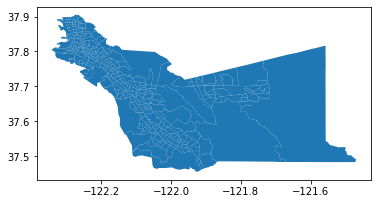

In [1135]:
final_equity_geom.plot()

In [1136]:
#final_equity_geom = gdf.merge(transpo_mhi_age,left_on='geoid',right_on='geoid_join')


final_equity_output = final_equity_geom.merge(ces_gdf_simplified, left_on='geoid_join', right_on='tract')


In [1137]:
print(type(final_equity_output))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [1138]:
final_equity_output

,statefp,countyfp,tractce,affgeoid,geoid_x,name,lsad,aland,awater,geometry,...,total_pop,age_18_under,age_65_over,age_vulnerable,pct_age_18_under,pct_age_65_over,pct_age_vulnerable,tract_y,CIscore,CIscoreP
0,06,001,425101,1400000US06001425101,06001425101,4251.01,CT,590870,2045459,"POLYGON ((-122.31419 37.84231, -122.29923 37.8...",...,1588,55,493,548,3.463476,31.045340,34.508816,06001425101,30.63,61
1,06,001,428600,1400000US06001428600,06001428600,4286,CT,898967,1080420,"POLYGON ((-122.27993 37.76818, -122.27849 37.7...",...,3471,525,824,1349,15.125324,23.739556,38.864880,06001428600,14.47,24
2,06,001,432600,1400000US06001432600,06001432600,4326,CT,1673450,0,"POLYGON ((-122.16751 37.72632, -122.16108 37.7...",...,7314,1296,939,2235,17.719442,12.838392,30.557834,06001432600,36.40,71
3,06,001,433200,1400000US06001433200,06001433200,4332,CT,3174901,0,"POLYGON ((-122.16667 37.71042, -122.15559 37.7...",...,7625,1944,951,2895,25.495082,12.472131,37.967213,06001433200,44.90,83
4,06,001,433900,1400000US06001433900,06001433900,4339,CT,816585,0,"POLYGON ((-122.12091 37.69998, -122.11723 37.7...",...,7440,2026,496,2522,27.231183,6.666667,33.897849,06001433900,32.01,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,06,001,427300,1400000US06001427300,06001427300,4273,CT,1950568,861367,"POLYGON ((-122.27671 37.77719, -122.27663 37.7...",...,5084,1057,728,1785,20.790716,14.319434,35.110149,06001427300,33.76,66
356,06,001,428400,1400000US06001428400,06001428400,4284,CT,810521,1168052,"POLYGON ((-122.25493 37.75988, -122.25462 37.7...",...,4653,852,701,1553,18.310767,15.065549,33.376316,06001428400,25.13,50
357,06,001,430600,1400000US06001430600,06001430600,4306,CT,2261416,0,"POLYGON ((-122.10628 37.70976, -122.10524 37.7...",...,6624,1264,1506,2770,19.082126,22.735507,41.817633,06001430600,14.94,25
358,06,001,451501,1400000US06001451501,06001451501,4515.01,CT,5051294,0,"POLYGON ((-121.76526 37.67997, -121.75512 37.6...",...,4751,1137,818,1955,23.931804,17.217428,41.149232,06001451501,26.20,52


In [1139]:
gdf.columns

Index(['statefp', 'countyfp', 'tractce', 'affgeoid', 'geoid', 'name', 'lsad',
       'aland', 'awater', 'geometry'],
      dtype='object')

In [1140]:
final_equity_output.to_file(Equity_Tracts)

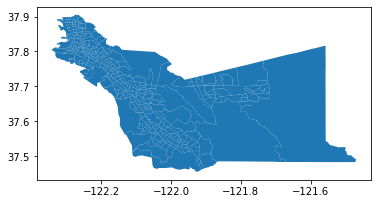

In [1141]:
final_equity_geom.plot()

In [1142]:
#Test that previous join error did not occur. 
final_equity_output.loc[final_equity_output['geoid_join']=='06001450752']

,statefp,countyfp,tractce,affgeoid,geoid_x,name,lsad,aland,awater,geometry,...,total_pop,age_18_under,age_65_over,age_vulnerable,pct_age_18_under,pct_age_65_over,pct_age_vulnerable,tract_y,CIscore,CIscoreP
322,06,001,450752,1400000US06001450752,06001450752,4507.52,CT,17421881,0,"POLYGON ((-121.88157 37.73733, -121.87354 37.7...",...,6642,2051,490,2541,30.879253,7.377296,38.256549,06001450752,17.21,31


In [1143]:
final_equity_output['geoid_join']

0      06001425101
1      06001428600
2      06001432600
3      06001433200
4      06001433900
          ...     
355    06001427300
356    06001428400
357    06001430600
358    06001451501
359    06001435102
Name: geoid_join, Length: 360, dtype: object

In [1144]:
#Export county level dataframes to excel

with pd.ExcelWriter(EXCEL_FP) as writer:
    df_age_county.to_excel(writer, sheet_name='county_age')
    df_transpo_mode_county.to_excel(writer, sheet_name='county_transpo_mode')
    df_mhi_county.to_excel(writer, sheet_name='county_mhi')

# OTHER EXAMPLES FOUND WHILE TROUBLESHOOTING
# with pd.ExcelWriter("test.xlsx", engine='openpyxl', mode='a') as writer:
#     df.to_excel(writer)
# with pd.ExcelWriter(Excel_FP) as writer:
#     bike_crashes_by_year.to_excel(writer, sheet_name='b_crashes_by_year')

In [1145]:
#SOURCES
#https://www.w3schools.com/tags/ref_urlencode.ASP
#https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf
#https://api.census.gov/data/2018/acs/acs5/variables.html
#https://api.census.gov/data/2018/acs/acs5/subject/variables.html
#https://www.youtube.com/watch?v=Wi0_Mb0e4JM
#https://atcoordinates.info/2019/09/24/examples-of-using-the-census-bureaus-api-with-python/
#--downloading tigerline from zip -- 
#http://andrewgaidus.com/Dot_Density_County_Maps/
#--Python for reading zip tigerline shpfile --
#http://andrewgaidus.com/Reading_Zipped_Shapefiles/
#--Aaron's ATP Data Mining Project would also be useful--
#https://github.com/AltaPlanning/GIS-notebooks/tree/master/2020-000%20ATP%20Data%20Mining
#https://automating-gis-processes.github.io/site/notebooks/L5/interactive-map-folium.html

#-- geographies and summary levels --
#https://censusreporter.org/topics/geography/
#geo_ids=140|04000US06  --> this should be a all tracts in California

#There is no great way to use the api to return census tract geometries: the geography api functions 
#only seem to allow calling a specific geoid. One option would be to loop through geoids and call census reporter
#to request geography for each geoid, but that would involve a lot of calls. 
#https://api.censusreporter.org/1.0/data/show/latest?table_ids=B01001&geo_ids=140|04000US06
#error"You requested 8057 geoids. The maximum is 3500. Please contact us for bulk data."



# MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) BY MEANS OF TRANSPORTATION TO WORK
# Survey/Program: American Community Survey
# Universe: Workers 16 years and over with earnings
# Year: 2018
# Estimates: 1-Year
# Table ID: B08121

# ### OTHER NOTES
#I was a bit confused about obtaining the Census Tiger boundaries. The Tigerweb REST service seemed geared towards
#delivering Web Map Service (WMS) map images. We want the spatial data! Hopefully the stack exchange post linked below
#clears some of the confusion up.
#https://gis.stackexchange.com/questions/269650/how-to-bring-the-tiger-census-reporter-api-to-geopandas
#--->I'm not sure if these geometries still exist on the census api. 
#zipfiles can be downloaded at the ftp site below. I am using blog and aaron's atp data mining python as examples. 
#For now I am just going to manually unzip census geometry, but a link to a tutorial is included below to automate
#download, unzipping, and processing the geometry. 

#ftp://ftp2.census.gov/geo/tiger/TIGER2018/TRACT/tl_2018_06_tract.zip

